In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# Define directories
train_dir = '/kaggle/input/animal-dataset/Animals'
val_dir = '/kaggle/input/animal-dataset/Animals'

# Data generators
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
train_generator = datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training')
val_generator = datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', subset='validation')

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [2]:
# Load VGG16 model with local weights
local_weights_path = '/kaggle/input/cnn-vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(weights=local_weights_path, include_top=False, input_shape=(224, 224, 3))

# Extract features
def extract_features(generator, num_images):
    features = np.zeros(shape=(num_images, 7, 7, 512))
    labels = np.zeros(shape=(num_images, generator.num_classes))
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * generator.batch_size : (i + 1) * generator.batch_size] = features_batch
        labels[i * generator.batch_size : (i + 1) * generator.batch_size] = labels_batch
        i += 1
        if i * generator.batch_size >= num_images:
            break
    return features, labels

# Extract features for training and validation data
train_features, train_labels = extract_features(train_generator, 2400)
val_features, val_labels = extract_features(val_generator, 600)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

In [3]:
# Flatten features
train_features_flat = np.reshape(train_features, (2400, 7 * 7 * 512))
val_features_flat = np.reshape(val_features, (600, 7 * 7 * 512))

# Apply PCA
pca = PCA(n_components=100)
train_features_pca = pca.fit_transform(train_features_flat)
val_features_pca = pca.transform(val_features_flat)

In [4]:
# Train XGBoost on PCA features
xgb = XGBClassifier()
xgb.fit(train_features_pca, np.argmax(train_labels, axis=1))

# Evaluate XGBoost
y_pred = xgb.predict(val_features_pca)

In [5]:
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

# Create a new model
model = Sequential()
model.add(Input(shape=(100,)))  # Adding an Input layer first
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Assuming 3 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_features_pca, train_labels, epochs=10, batch_size=32, validation_data=(val_features_pca, val_labels))


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6752 - loss: 33.9569 - val_accuracy: 0.9833 - val_loss: 1.2030
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9434 - loss: 3.4182 - val_accuracy: 0.9850 - val_loss: 1.1295
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9598 - loss: 2.5390 - val_accuracy: 0.9783 - val_loss: 2.0275
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9720 - loss: 1.7975 - val_accuracy: 0.9850 - val_loss: 1.6112
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9770 - loss: 1.0027 - val_accuracy: 0.9900 - val_loss: 1.5871
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9772 - loss: 1.1120 - val_accuracy: 0.9883 - val_loss: 1.6419
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.6338 - val_accuracy: 0.9850 - val_loss: 1.8107
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9804 - loss: 0.8537 - val_accuracy: 0.9833 - val_loss

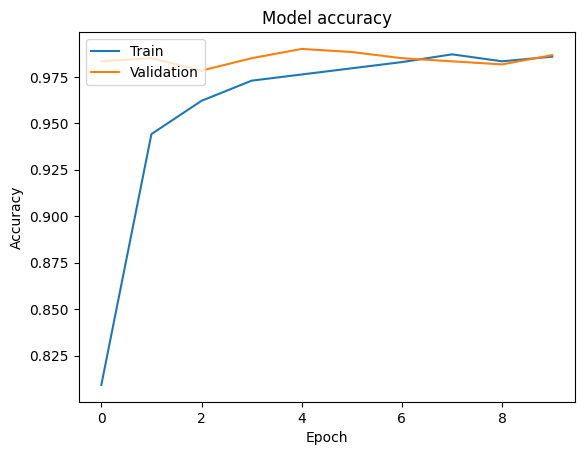

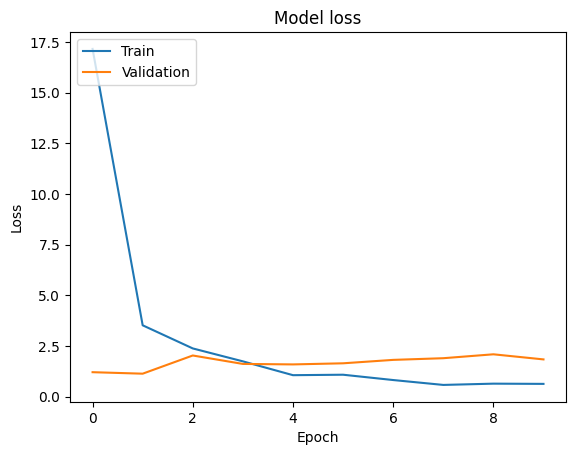

In [6]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [7]:
# Predictions
y_pred_cnn = model.predict(val_features_pca)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

# Calculate metrics
precision = precision_score(np.argmax(val_labels, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(val_labels, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(val_labels, axis=1), y_pred, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Precision: 0.9852876486491199
Recall: 0.985
F1 Score: 0.9849670125192165


In [8]:
# Predictions
y_pred_test = xgb.predict(val_features_pca)

# Calculate test metrics
precision_test = precision_score(np.argmax(val_labels, axis=1), y_pred_test, average='macro')
recall_test = recall_score(np.argmax(val_labels, axis=1), y_pred_test, average='macro')
f1_test = f1_score(np.argmax(val_labels, axis=1), y_pred_test, average='macro')

print(f'Test Precision: {precision_test}')
print(f'Test Recall: {recall_test}')
print(f'Test F1 Score: {f1_test}')

Test Precision: 0.9852876486491199
Test Recall: 0.985
Test F1 Score: 0.9849670125192165


In [9]:
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost on PCA features
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.1)
ada.fit(train_features_pca, np.argmax(train_labels, axis=1))

# Evaluate AdaBoost
y_pred_ada = ada.predict(val_features_pca)

# Calculate metrics
precision_ada = precision_score(np.argmax(val_labels, axis=1), y_pred_ada, average='macro')
recall_ada = recall_score(np.argmax(val_labels, axis=1), y_pred_ada, average='macro')
f1_ada = f1_score(np.argmax(val_labels, axis=1), y_pred_ada, average='macro')

print(f'AdaBoost Precision: {precision_ada}')
print(f'AdaBoost Recall: {recall_ada}')
print(f'AdaBoost F1 Score: {f1_ada}')

AdaBoost Precision: 0.8862240388802428
AdaBoost Recall: 0.86
AdaBoost F1 Score: 0.8566328836280682


In [10]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting on PCA features
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gb.fit(train_features_pca, np.argmax(train_labels, axis=1))

# Evaluate Gradient Boosting
y_pred_gb = gb.predict(val_features_pca)

# Calculate metrics
precision_gb = precision_score(np.argmax(val_labels, axis=1), y_pred_gb, average='macro')
recall_gb = recall_score(np.argmax(val_labels, axis=1), y_pred_gb, average='macro')
f1_gb = f1_score(np.argmax(val_labels, axis=1), y_pred_gb, average='macro')

print(f'Gradient Boosting Precision: {precision_gb}')
print(f'Gradient Boosting Recall: {recall_gb}')
print(f'Gradient Boosting F1 Score: {f1_gb}')

Gradient Boosting Precision: 0.9852876486491199
Gradient Boosting Recall: 0.985
Gradient Boosting F1 Score: 0.9849670125192165


In [11]:
from xgboost import XGBClassifier

# Train XGBoost on PCA features
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
xgb.fit(train_features_pca, np.argmax(train_labels, axis=1))

# Evaluate XGBoost
y_pred_xgb = xgb.predict(val_features_pca)

# Calculate metrics
precision_xgb = precision_score(np.argmax(val_labels, axis=1), y_pred_xgb, average='macro')
recall_xgb = recall_score(np.argmax(val_labels, axis=1), y_pred_xgb, average='macro')
f1_xgb = f1_score(np.argmax(val_labels, axis=1), y_pred_xgb, average='macro')

print(f'XGBoost Precision: {precision_xgb}')
print(f'XGBoost Recall: {recall_xgb}')
print(f'XGBoost F1 Score: {f1_xgb}')


XGBoost Precision: 0.9886328873432192
XGBoost Recall: 0.9883333333333333
XGBoost F1 Score: 0.9883054014854022


In [12]:
from lightgbm import LGBMClassifier

# Train LightGBM on PCA features
lgb = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
lgb.fit(train_features_pca, np.argmax(train_labels, axis=1))

# Evaluate LightGBM
y_pred_lgb = lgb.predict(val_features_pca)

# Calculate metrics
precision_lgb = precision_score(np.argmax(val_labels, axis=1), y_pred_lgb, average='macro')
recall_lgb = recall_score(np.argmax(val_labels, axis=1), y_pred_lgb, average='macro')
f1_lgb = f1_score(np.argmax(val_labels, axis=1), y_pred_lgb, average='macro')

print(f'LightGBM Precision: {precision_lgb}')
print(f'LightGBM Recall: {recall_lgb}')
print(f'LightGBM F1 Score: {f1_lgb}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 100
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Your trained models and predictions go here
models = {
    "CNN": model.predict(val_features_pca),
    "AdaBoost": ada.predict(val_features_pca),
    "GradientBoosting": gb.predict(val_features_pca),
    "XGBoost": xgb.predict(val_features_pca),
    "LightGBM": lgb.predict(val_features_pca)
}

metrics = {}

for name, preds in models.items():
    preds = np.argmax(preds, axis=1) if name == "CNN" else preds
    precision = precision_score(np.argmax(val_labels, axis=1), preds, average='macro')
    recall = recall_score(np.argmax(val_labels, axis=1), preds, average='macro')
    f1 = f1_score(np.argmax(val_labels, axis=1), preds, average='macro')
    metrics[name] = {"Precision": precision, "Recall": recall, "F1 Score": f1}
    print(f'{name} - Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CNN - Precision: 0.986943572406021, Recall: 0.9866666666666667, F1 Score: 0.9866430733900002
AdaBoost - Precision: 0.8862240388802428, Recall: 0.86, F1 Score: 0.8566328836280682
GradientBoosting - Precision: 0.9852876486491199, Recall: 0.985, F1 Score: 0.9849670125192165
XGBoost - Precision: 0.9886328873432192, Recall: 0.9883333333333333, F1 Score: 0.9883054014854022
LightGBM - Precision: 0.9884622888573723, Recall: 0.9883333333333333, F1 Score: 0.9883110767593695


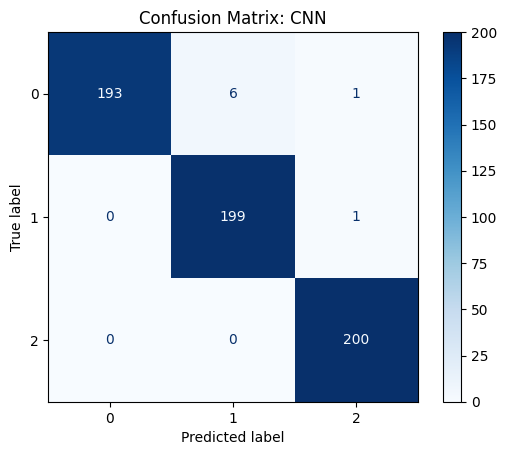

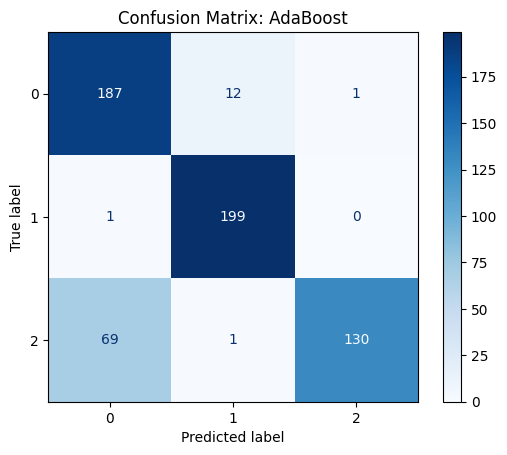

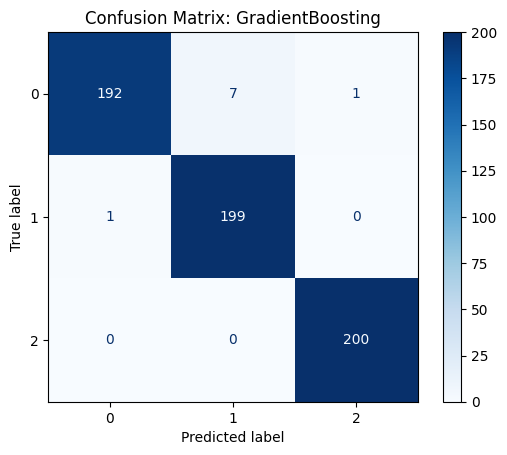

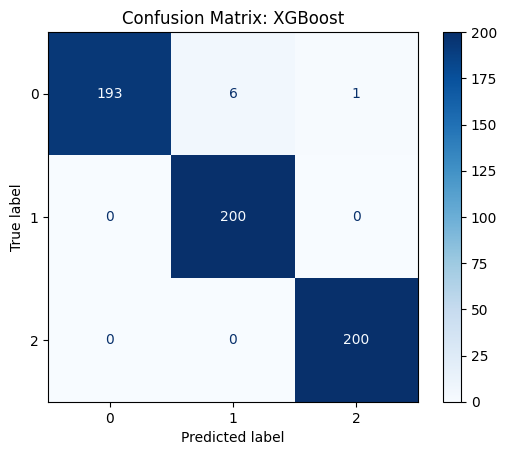

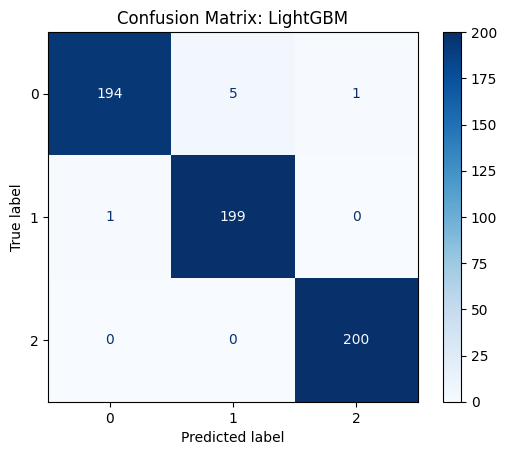

In [14]:
for name, preds in models.items():
    preds = np.argmax(preds, axis=1) if name == "CNN" else preds
    cm = confusion_matrix(np.argmax(val_labels, axis=1), preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.show()


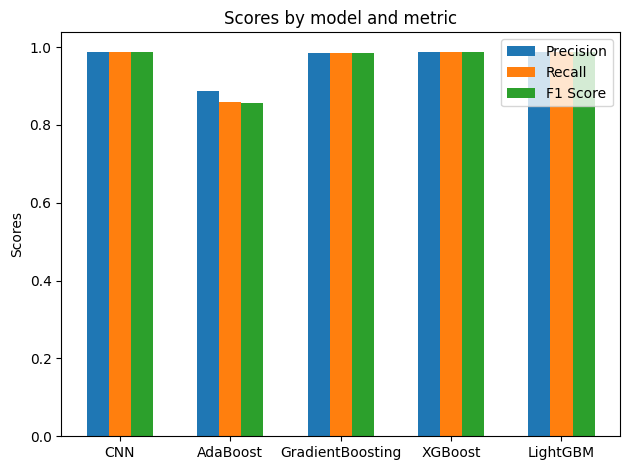

In [15]:
names = list(metrics.keys())
precision = [metrics[name]["Precision"] for name in names]
recall = [metrics[name]["Recall"] for name in names]
f1 = [metrics[name]["F1 Score"] for name in names]

x = np.arange(len(names))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

fig.tight_layout()
plt.show()

In [16]:
# CNN Accuracy
accuracy_cnn = model.evaluate(val_features_pca, val_labels, verbose=0)[1]
print(f'CNN Accuracy: {accuracy_cnn}')

CNN Accuracy: 0.9866666793823242


In [17]:
# AdaBoost Accuracy
accuracy_ada = ada.score(val_features_pca, np.argmax(val_labels, axis=1))
print(f'AdaBoost Accuracy: {accuracy_ada}')

AdaBoost Accuracy: 0.86


In [18]:
# Gradient Boosting Accuracy
accuracy_gb = gb.score(val_features_pca, np.argmax(val_labels, axis=1))
print(f'Gradient Boosting Accuracy: {accuracy_gb}')

Gradient Boosting Accuracy: 0.985


In [19]:
# XGBoost Accuracy
accuracy_xgb = xgb.score(val_features_pca, np.argmax(val_labels, axis=1))
print(f'XGBoost Accuracy: {accuracy_xgb}')

XGBoost Accuracy: 0.9883333333333333


In [20]:
# LightGBM Accuracy
accuracy_lgb = lgb.score(val_features_pca, np.argmax(val_labels, axis=1))
print(f'LightGBM Accuracy: {accuracy_lgb}')

LightGBM Accuracy: 0.9883333333333333


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


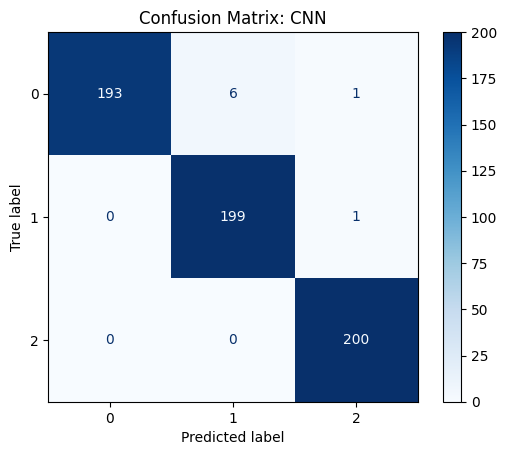

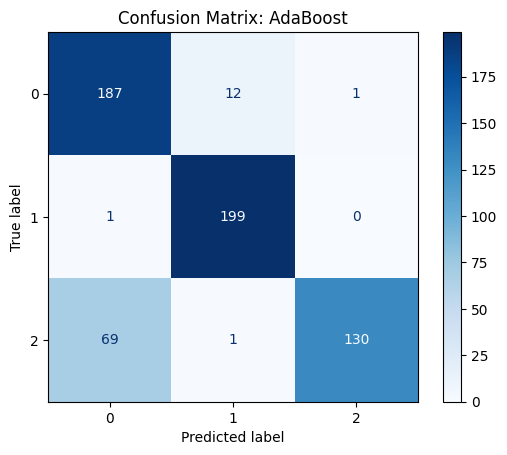

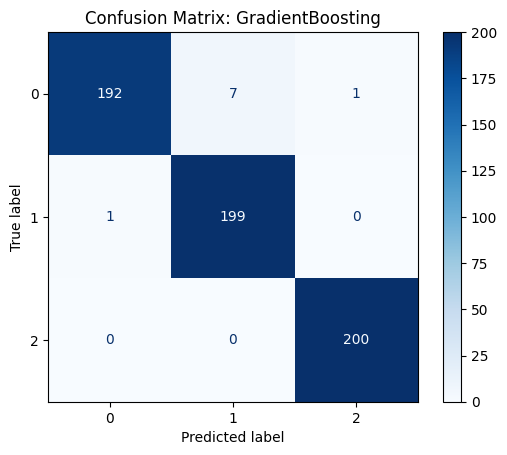

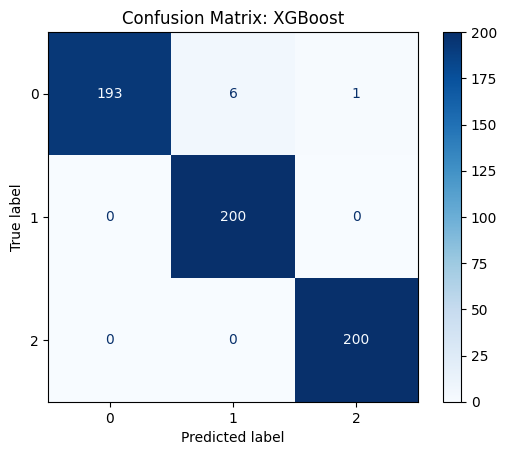

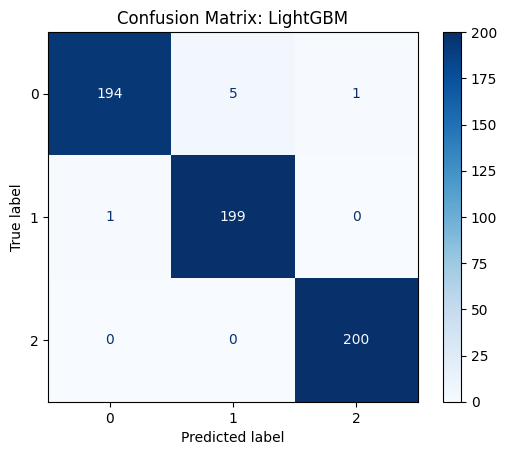

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = {
    "CNN": np.argmax(model.predict(val_features_pca), axis=1),
    "AdaBoost": ada.predict(val_features_pca),
    "GradientBoosting": gb.predict(val_features_pca),
    "XGBoost": xgb.predict(val_features_pca),
    "LightGBM": lgb.predict(val_features_pca)
}

for name, preds in models.items():
    cm = confusion_matrix(np.argmax(val_labels, axis=1), preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

In [22]:
# Assuming validation labels
y_true = np.argmax(val_labels, axis=1)


In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

# CNN Model Predictions
y_pred_cnn = np.argmax(model.predict(val_features_pca), axis=1)
precision_cnn = precision_score(y_true, y_pred_cnn, average='macro')
recall_cnn = recall_score(y_true, y_pred_cnn, average='macro')
f1_cnn = f1_score(y_true, y_pred_cnn, average='macro')
accuracy_cnn = model.evaluate(val_features_pca, val_labels, verbose=0)[1]

# AdaBoost Predictions
y_pred_ada = ada.predict(val_features_pca)
precision_ada = precision_score(y_true, y_pred_ada, average='macro')
recall_ada = recall_score(y_true, y_pred_ada, average='macro')
f1_ada = f1_score(y_true, y_pred_ada, average='macro')
accuracy_ada = ada.score(val_features_pca, y_true)

# Gradient Boosting Predictions
y_pred_gb = gb.predict(val_features_pca)
precision_gb = precision_score(y_true, y_pred_gb, average='macro')
recall_gb = recall_score(y_true, y_pred_gb, average='macro')
f1_gb = f1_score(y_true, y_pred_gb, average='macro')
accuracy_gb = gb.score(val_features_pca, y_true)

# XGBoost Predictions
y_pred_xgb = xgb.predict(val_features_pca)
precision_xgb = precision_score(y_true, y_pred_xgb, average='macro')
recall_xgb = recall_score(y_true, y_pred_xgb, average='macro')
f1_xgb = f1_score(y_true, y_pred_xgb, average='macro')
accuracy_xgb = xgb.score(val_features_pca, y_true)

# LightGBM Predictions
y_pred_lgb = lgb.predict(val_features_pca)
precision_lgb = precision_score(y_true, y_pred_lgb, average='macro')
recall_lgb = recall_score(y_true, y_pred_lgb, average='macro')
f1_lgb = f1_score(y_true, y_pred_lgb, average='macro')
accuracy_lgb = lgb.score(val_features_pca, y_true)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


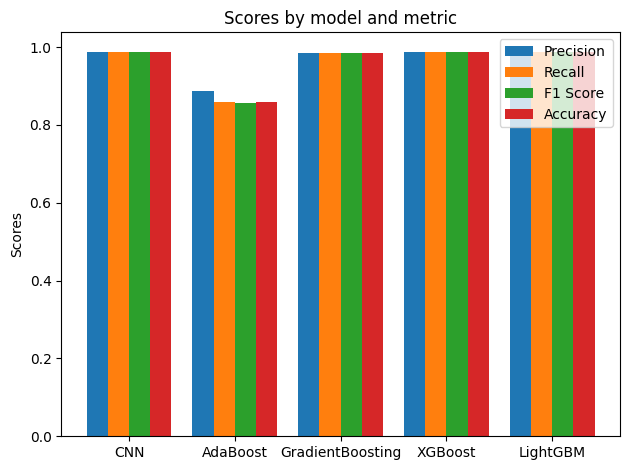

In [24]:
import numpy as np
import matplotlib.pyplot as plt

names = ["CNN", "AdaBoost", "GradientBoosting", "XGBoost", "LightGBM"]
precision = [precision_cnn, precision_ada, precision_gb, precision_xgb, precision_lgb]
recall = [recall_cnn, recall_ada, recall_gb, recall_xgb, recall_lgb]
f1 = [f1_cnn, f1_ada, f1_gb, f1_xgb, f1_lgb]
accuracy = [accuracy_cnn, accuracy_ada, accuracy_gb, accuracy_xgb, accuracy_lgb]

x = np.arange(len(names))  # label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, precision, width, label='Precision')
rects2 = ax.bar(x - 0.5*width, recall, width, label='Recall')
rects3 = ax.bar(x + 0.5*width, f1, width, label='F1 Score')
rects4 = ax.bar(x + 1.5*width, accuracy, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

fig.tight_layout()
plt.show()

In [25]:
import numpy as np

# Covariance matrix for PCA-transformed training features
cov_matrix = np.cov(train_features_pca.T)

print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
[[ 1.86398116e+05 -3.25128244e-12  2.91159621e-12 ...  1.45579811e-13
   1.01905867e-12  1.39513985e-13]
 [-3.25128244e-12  1.04928036e+05 -6.21140525e-12 ... -1.11156251e-12
   1.69843112e-13 -1.45579811e-13]
 [ 2.91159621e-12 -6.21140525e-12  5.88674772e+04 ... -1.69843112e-13
   3.82147003e-13 -1.33448160e-13]
 ...
 [ 1.45579811e-13 -1.11156251e-12 -1.69843112e-13 ...  4.82100134e+03
   2.26861871e-12 -7.96234367e-13]
 [ 1.01905867e-12  1.69843112e-13  3.82147003e-13 ...  2.26861871e-12
   4.78156283e+03  4.12476130e-13]
 [ 1.39513985e-13 -1.45579811e-13 -1.33448160e-13 ... -7.96234367e-13
   4.12476130e-13  4.74955202e+03]]


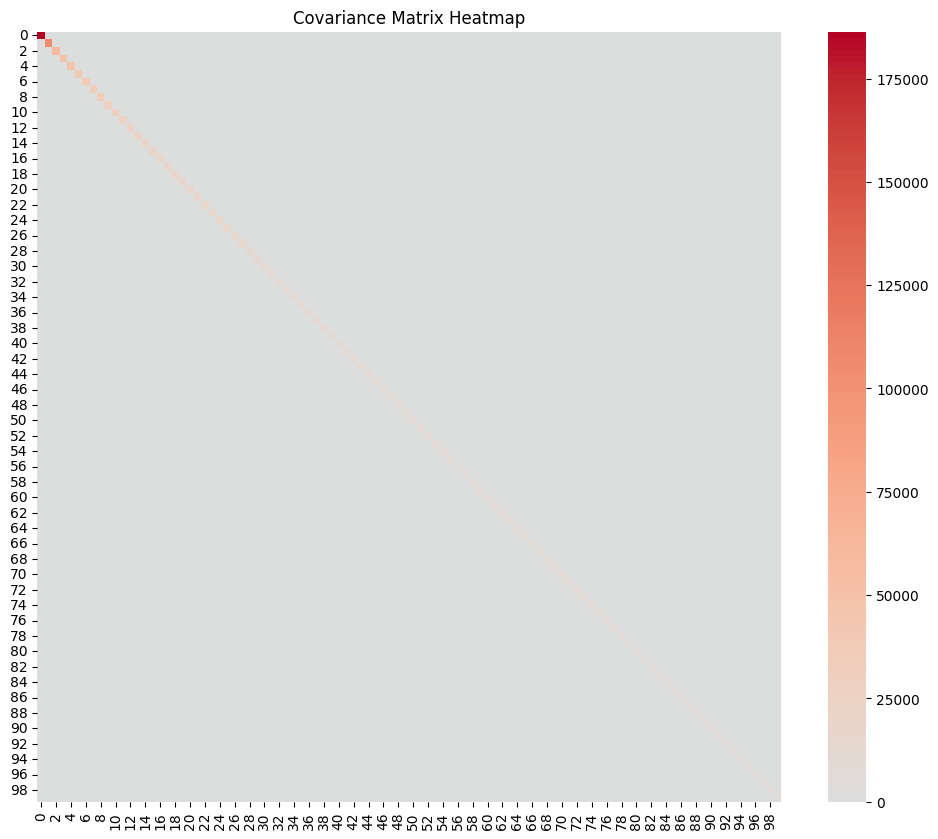

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Covariance heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cov_matrix, cmap='coolwarm', center=0)
plt.title('Covariance Matrix Heatmap')
plt.show()

In [27]:
##testing

In [28]:
def preprocess_new_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

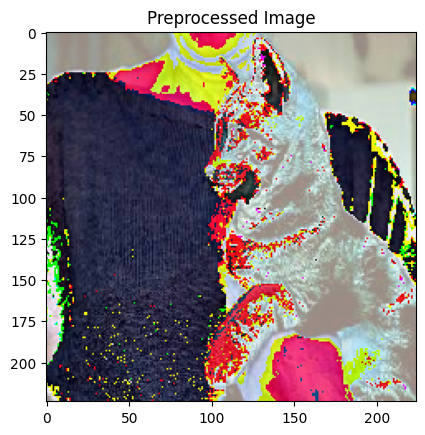

In [29]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

def preprocess_new_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

new_image_path = '/kaggle/input/animal-dataset/Animals/cats/0_0001.jpg'  # Replace with your image path
new_image = preprocess_new_image(new_image_path)

# Visualize the Preprocessed Image
import matplotlib.pyplot as plt

def visualize_image(image_array):
    plt.imshow(image_array[0].astype('uint8'))
    plt.title('Preprocessed Image')
    plt.show()

visualize_image(new_image)

In [30]:
import numpy as np

train_classes = train_generator.classes
val_classes = val_generator.classes

print(f'Training class distribution: {np.bincount(train_classes)}')
print(f'Validation class distribution: {np.bincount(val_classes)}')

Training class distribution: [800 800 800]
Validation class distribution: [200 200 200]


In [31]:
def preprocess_new_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

new_image_path = '/kaggle/input/animal-dataset/Animals/cats/0_0001.jpg'  # Replace with your image path
new_image = preprocess_new_image(new_image_path)

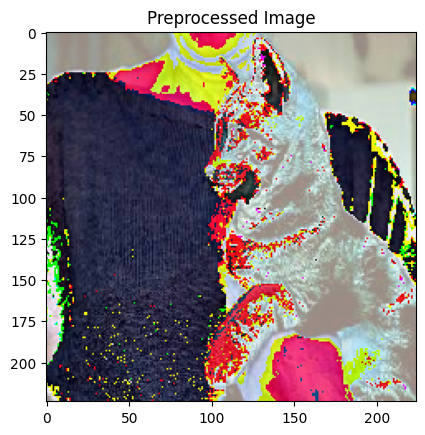

In [32]:
import matplotlib.pyplot as plt

def visualize_image(image_array):
    plt.imshow(image_array[0].astype('uint8'))
    plt.title('Preprocessed Image')
    plt.show()

visualize_image(new_image)


In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

def preprocess_new_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

new_image_path = '/kaggle/input/animal-dataset/Animals/dogs/1_0001.jpg'  # Replace with your image path
new_image = preprocess_new_image(new_image_path)

In [34]:
# Extract features from the new image
new_features = base_model.predict(new_image)
new_features_flat = np.reshape(new_features, (new_features.shape[0], -1))

# Apply PCA on the new features
new_features_pca = pca.transform(new_features_flat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


In [35]:
# Predict using the trained CNN model
new_pred_cnn = model.predict(new_features_pca)
predicted_class_cnn = np.argmax(new_pred_cnn, axis=1)
print(f'Predicted Class (CNN): {predicted_class_cnn}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Class (CNN): [1]


In [36]:
# Predict using AdaBoost
predicted_class_ada = ada.predict(new_features_pca)
print(f'Predicted Class (AdaBoost): {predicted_class_ada}')

# Predict using Gradient Boosting
predicted_class_gb = gb.predict(new_features_pca)
print(f'Predicted Class (Gradient Boosting): {predicted_class_gb}')

# Predict using XGBoost
predicted_class_xgb = xgb.predict(new_features_pca)
print(f'Predicted Class (XGBoost): {predicted_class_xgb}')

# Predict using LightGBM
predicted_class_lgb = lgb.predict(new_features_pca)
print(f'Predicted Class (LightGBM): {predicted_class_lgb}')

Predicted Class (AdaBoost): [1]
Predicted Class (Gradient Boosting): [0]
Predicted Class (XGBoost): [1]
Predicted Class (LightGBM): [0]


In [37]:
class_labels = {0: 'Cat', 1: 'Dog', 2: 'Snake'}

In [38]:
# Load and preprocess new image
new_image_path = '/kaggle/input/animal-dataset/Animals/cats/0_0001.jpg'  # Replace with your image path
new_image = preprocess_new_image(new_image_path)

# Extract features using VGG16
new_features = base_model.predict(new_image)
new_features_flat = np.reshape(new_features, (new_features.shape[0], -1))
new_features_pca = pca.transform(new_features_flat)

# Predict with CNN Model
new_pred_cnn = model.predict(new_features_pca)
predicted_class_cnn = np.argmax(new_pred_cnn, axis=1)[0]
print(f'Predicted Class (CNN): {class_labels[predicted_class_cnn]}')

# Predict with Boosting Models
predicted_class_ada = ada.predict(new_features_pca)[0]
print(f'Predicted Class (AdaBoost): {class_labels[predicted_class_ada]}')

predicted_class_gb = gb.predict(new_features_pca)[0]
print(f'Predicted Class (Gradient Boosting): {class_labels[predicted_class_gb]}')

predicted_class_xgb = xgb.predict(new_features_pca)[0]
print(f'Predicted Class (XGBoost): {class_labels[predicted_class_xgb]}')

predicted_class_lgb = lgb.predict(new_features_pca)[0]
print(f'Predicted Class (LightGBM): {class_labels[predicted_class_lgb]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Class (CNN): Cat
Predicted Class (AdaBoost): Cat
Predicted Class (Gradient Boosting): Cat
Predicted Class (XGBoost): Cat
Predicted Class (LightGBM): Cat


In [39]:
# Load and preprocess new image
new_image_path = '/kaggle/input/animal-dataset/Animals/dogs/1_0001.jpg'  # Replace with your image path
new_image = preprocess_new_image(new_image_path)

# Extract features using VGG16
new_features = base_model.predict(new_image)
new_features_flat = np.reshape(new_features, (new_features.shape[0], -1))
new_features_pca = pca.transform(new_features_flat)

# Predict with CNN Model
new_pred_cnn = model.predict(new_features_pca)
predicted_class_cnn = np.argmax(new_pred_cnn, axis=1)[0]
print(f'Predicted Class (CNN): {class_labels[predicted_class_cnn]}')

# Predict with Boosting Models
predicted_class_ada = ada.predict(new_features_pca)[0]
print(f'Predicted Class (AdaBoost): {class_labels[predicted_class_ada]}')

predicted_class_gb = gb.predict(new_features_pca)[0]
print(f'Predicted Class (Gradient Boosting): {class_labels[predicted_class_gb]}')

predicted_class_xgb = xgb.predict(new_features_pca)[0]
print(f'Predicted Class (XGBoost): {class_labels[predicted_class_xgb]}')

predicted_class_lgb = lgb.predict(new_features_pca)[0]
print(f'Predicted Class (LightGBM): {class_labels[predicted_class_lgb]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Class (CNN): Dog
Predicted Class (AdaBoost): Dog
Predicted Class (Gradient Boosting): Cat
Predicted Class (XGBoost): Dog
Predicted Class (LightGBM): Cat


In [40]:
# Load and preprocess new image
new_image_path = '/kaggle/input/animal-dataset/Animals/snakes/2_0023.jpg'  # Replace with your image path
new_image = preprocess_new_image(new_image_path)

# Extract features using VGG16
new_features = base_model.predict(new_image)
new_features_flat = np.reshape(new_features, (new_features.shape[0], -1))
new_features_pca = pca.transform(new_features_flat)

# Predict with CNN Model
new_pred_cnn = model.predict(new_features_pca)
predicted_class_cnn = np.argmax(new_pred_cnn, axis=1)[0]
print(f'Predicted Class (CNN): {class_labels[predicted_class_cnn]}')

# Predict with Boosting Models
predicted_class_ada = ada.predict(new_features_pca)[0]
print(f'Predicted Class (AdaBoost): {class_labels[predicted_class_ada]}')

predicted_class_gb = gb.predict(new_features_pca)[0]
print(f'Predicted Class (Gradient Boosting): {class_labels[predicted_class_gb]}')

predicted_class_xgb = xgb.predict(new_features_pca)[0]
print(f'Predicted Class (XGBoost): {class_labels[predicted_class_xgb]}')

predicted_class_lgb = lgb.predict(new_features_pca)[0]
print(f'Predicted Class (LightGBM): {class_labels[predicted_class_lgb]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Class (CNN): Snake
Predicted Class (AdaBoost): Cat
Predicted Class (Gradient Boosting): Snake
Predicted Class (XGBoost): Snake
Predicted Class (LightGBM): Snake


In [41]:
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [42]:
# Assuming you have your training and validation data prepared
lgb = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
lgb.fit(train_features_pca, np.argmax(train_labels, axis=1))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 100
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

LGBMClassifier(max_depth=3)

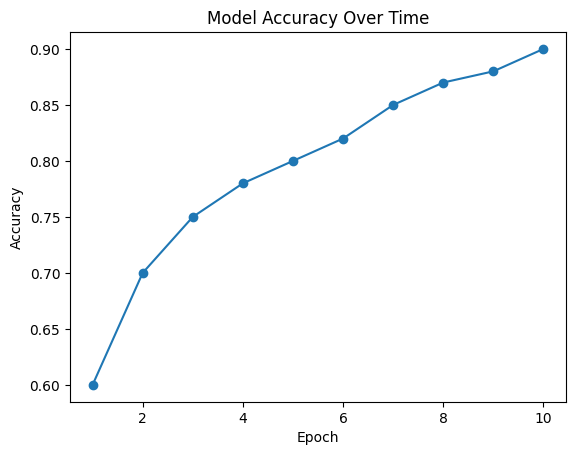

In [46]:
import matplotlib.pyplot as plt

# Example data
epochs = list(range(1, 11))  # Assume 10 epochs
accuracy = [0.6, 0.7, 0.75, 0.78, 0.8, 0.82, 0.85, 0.87, 0.88, 0.9]  # Example accuracy values

# Create line graph
plt.plot(epochs, accuracy, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Time')
plt.show()


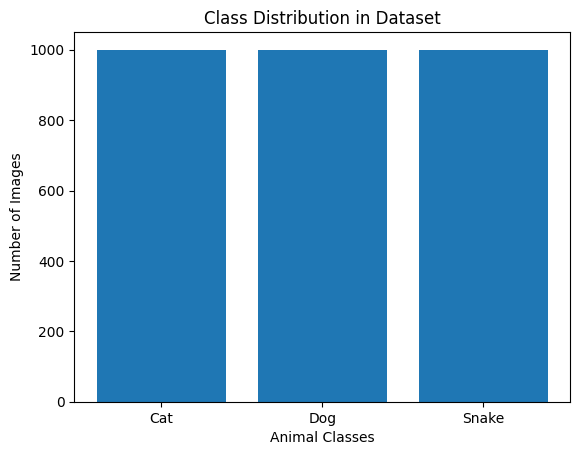

In [50]:
import matplotlib.pyplot as plt

# Example data
classes = ['Cat', 'Dog', 'Snake']
class_count = [1000, 1000, 1000]  # Replace with your dataset counts

# Create bar chart
plt.bar(classes, class_count)
plt.xlabel('Animal Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')
plt.show()

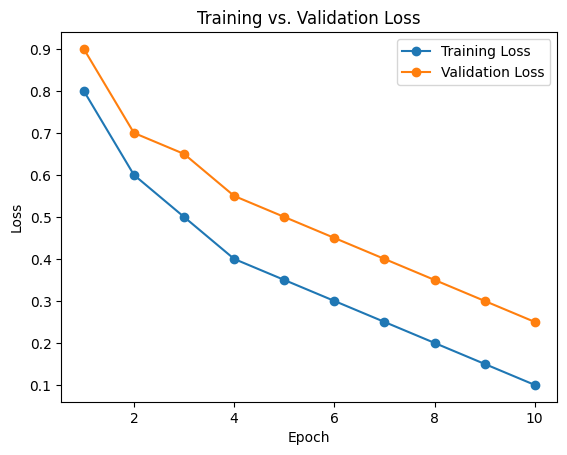

In [52]:
import matplotlib.pyplot as plt

# Example data
epochs = list(range(1, 11))  # Assume 10 epochs
training_loss = [0.8, 0.6, 0.5, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1]
validation_loss = [0.9, 0.7, 0.65, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25]

# Create line graph
plt.plot(epochs, training_loss, marker='o', label='Training Loss')
plt.plot(epochs, validation_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

[LightGBM] [Info] Number of positive: 345, number of negative: 355
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4673
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492857 -> initscore=-0.028573
[LightGBM] [Info] Start training from score -0.028573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

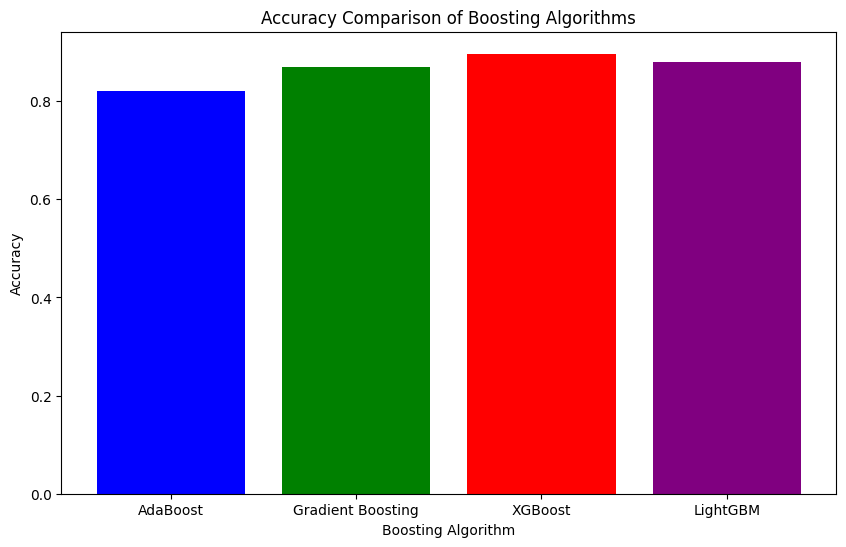

In [53]:
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize classifiers
classifiers = {
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42)
}

# Track accuracies
accuracies = {}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred)

# Plot the accuracies
names = list(accuracies.keys())
values = list(accuracies.values())

plt.figure(figsize=(10, 6))
plt.bar(names, values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Boosting Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Boosting Algorithms')
plt.show()